In [792]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import tensorflow as tf

In [793]:
# Считываем данные в датафрейм weather
weather = pd.read_excel('seattle-weather.xlsx')

In [794]:
weather.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [795]:
TRAIN_SPLIT = 1023
tf.random.set_seed(13)

In [796]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  """
  Функция, которая преобразует данные в формат, подходящий для обучения RNN.
  Принимает на вход набор данных (dataset), начальный индекс (start_index),
  конечный индекс (end_index), размер истории (history_size) и размер цели (target_size).
  Возвращает массивы данных (data) и меток (labels) для обучения.

  Аргументы:
  - dataset: набор данных
  - start_index: начальный индекс для выборки данных
  - end_index: конечный индекс для выборки данных (если не указан, используется конец набора данных)
  - history_size: размер истории
  - target_size: размер цели

  Возвращает:
  - data: массив данных, где каждый элемент представляет собой историю размера history_size
  - labels: массив меток, где каждая метка соответствует соответствующему элементу данных
  """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None or end_index > len(dataset) - target_size:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Преобразуем данные из формата (history_size,) в формат (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [797]:
# # Переделываем столбец date

# # Преобразование столбца 'Дата' в формат даты и времени
# weather['date'] = pd.to_datetime(weather['date'])

# # Форматирование столбца 'Дата' в формат 'yy-mm-dd HH'
# weather['date'] = weather['date'].dt.strftime('%y-%m-%d')

# # Установка столбца 'Дата' в качестве индекса данных
# weather.set_index('date', inplace=True)

# weather.head()

**Прогнозирование осадков на основе одномерного временного ряда**
 

In [798]:
# # Переделываем столбец precipitation в тип str

# weather['precipitation'] = weather['precipitation'].astype(str)
# weather['precipitation'].dtype

In [799]:
# Извлекаем только столбец precipitation

weather_prec = weather['precipitation']
weather_prec.index = weather['date']
weather_prec.head()

# uni_data = weather['precipitation']
# uni_data.index = weather['date']
# uni_data.head()

date
2012-01-01     0.0
2012-01-02    10.9
2012-01-03     0.8
2012-01-04    20.3
2012-01-05     1.3
Name: precipitation, dtype: float64

array([<Axes: xlabel='date'>], dtype=object)

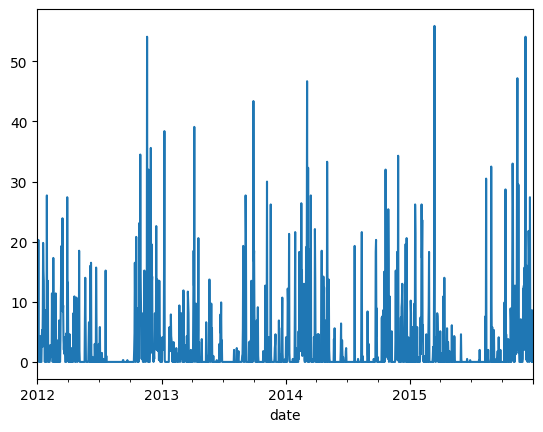

In [800]:
# # Смотрим, как данные изменяются во времени

# weather_prec.plot(figsize=(18, 6))
# plt.title('График измнения данных осадков во времени')
# plt.grid()
# plt.show()

weather_prec.plot(subplots=True)

In [801]:
weather_prec = weather_prec.values

In [802]:
# train_precipitation = weather_prec[:TRAIN_SPLIT]
# test_precipitation = weather_prec[TRAIN_SPLIT:]

In [803]:
# train_precipitation

In [804]:
# test_precipitation

Перед обучением искусственной нейронной сети важным шагом является масштабирование данных.
Поэтому нормализуем данные в колонке precipitation

In [805]:
# Вычислим среднее и стандартное отклонение

train_mean = weather_prec[1:TRAIN_SPLIT].mean()
train_std = weather_prec[:TRAIN_SPLIT].std()

In [806]:
train_mean

2.856849315068493

In [807]:
train_std

6.184268872747344

In [808]:
# Нормализация данных

weather_prec = (weather_prec-train_mean)/train_std

In [809]:
train_mean = weather_prec[:TRAIN_SPLIT].mean()
train_std = weather_prec[:TRAIN_SPLIT].std()

При стандартизации данных среднее знач должно быть равно 0, а стандартное отклонение - 1

In [810]:
train_mean

-0.000451568185953167

In [811]:
train_std

1.0

Полготовим данные к прогнозированию

In [812]:
import warnings

warnings.simplefilter(action = 'ignore', category = Warning) # Игнорируем все ограничения


univariate_past_history = 20 # На вход будут подаваться последние 20 наблюдений
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(weather_prec, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(weather_prec, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [813]:
# Результаты применения функции univariate_data

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[-0.46195425]
 [ 1.30058231]
 [-0.33259377]
 [ 2.82056797]
 [-0.25174347]
 [-0.05770275]
 [-0.46195425]
 [-0.46195425]
 [ 0.23335833]
 [-0.30025365]
 [-0.46195425]
 [-0.46195425]
 [-0.46195425]
 [ 0.20101821]
 [ 0.39505894]
 [-0.05770275]
 [ 0.84782062]
 [ 2.73971767]
 [ 1.9958949 ]
 [ 1.72100387]]

 Target to predict
0.023147551938166727


In [814]:
def create_time_steps(length):
  return list(range(-length, 0))

In [815]:
# Функция для отображения графиков

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Для прогноза значения будем использовать рекуррентную нейронную сеть(LSTM - 'Долгая краткосрочная память')

Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных, для того чтобы 

In [816]:
# Перемешивание (shuffling) используется для того, чтобы данные из которых обучается LSTM не были последовательными. В противном случае, LSTM может «подхватывать» общие шаблоны, и обучаться на них, а не на конкретных данных. Перемешивание гарантирует, что LSTM будет обучаться на разных данных с каждой итерацией, что улучшает качество обучения.

# Пакетирование (batching) позволяет обучать LSTM порциями, а не по одному примеру. Это повышает производительность, так как LSTM может работать с несколькими данными одновременно. Например, для обучения LSTM на 100 000 примерах потребуется 100 000 итераций, если данные обучаются по одному примеру. Если данные пакетируются по 32 примера в пакет, то потребуется только 3125 итераций для обучения LSTM на те же данные.

# Кэширование (caching) позволяет сохранять в памяти уже обработанные данные, чтобы их не нужно было снова обрабатывать, если данные будут использоваться несколько раз. Это особенно полезно, если данные требуются для нескольких задач, или если данные требуются несколько раз. Для кэширования в Python можно использовать модуль cachetools.

In [817]:
BATCH_SIZE = 120 # Задаем кол-во данных в 1м батче
BUFFER_SIZE = 1000 # Задаем размер буфера, в котором будут храниться данные перед размешиванием

# Создаем TensorFlow Dataset для обучающих данных
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# Кэшируем данные и перемешиваем их
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Создаем TensorFlow Dataset для валидационных данных
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
# Бatch-разбиваем данные и повторяем цикл
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Создаем модель LSTM

In [818]:
# Создаем модель LSTM с двумя слоями: LSTM и Dense

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]), # 1ый слой - 8 нейронов и со входом x_train_prec
    tf.keras.layers.Dense(1) # 2ой слой - 1 нейрон, который выводит результат
])

# Компилируем модель с адамовим оптимизатором и средним квадратичным ошибкой
simple_lstm_model.compile(optimizer='adam', loss='mae')


# Adam Optimizer – это алгоритм стохастической оптимизации, который сочетает в себе преимущества скорости адаптивного обучения и импульса для обновления параметров модели.

In [819]:
# Проверяем выход модели

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(120, 1)


In [820]:
EVALUATION_INTERVAL = 120
EPOCHS = 9

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=30)

Epoch 1/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5638 - val_loss: 0.5127
Epoch 2/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4458 - val_loss: 0.5161
Epoch 3/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4354 - val_loss: 0.5008
Epoch 4/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4334 - val_loss: 0.5127
Epoch 5/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4273 - val_loss: 0.4988
Epoch 6/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4280 - val_loss: 0.5115
Epoch 7/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4254 - val_loss: 0.4979
Epoch 8/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4265 - val_loss: 0.5111
Epoch 9/9
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4317 - val_loss: 0.4978


Прогнозирование с использованием простой модели LSTM

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


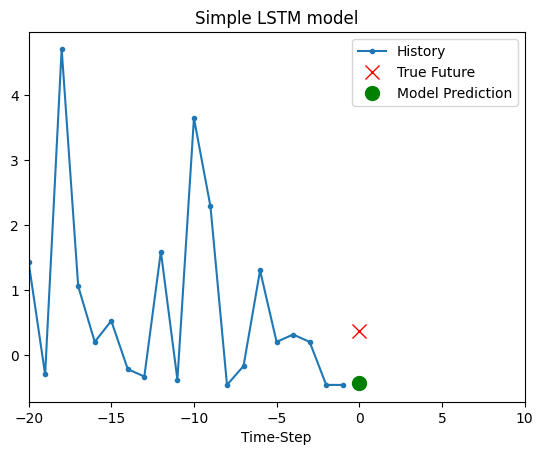

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


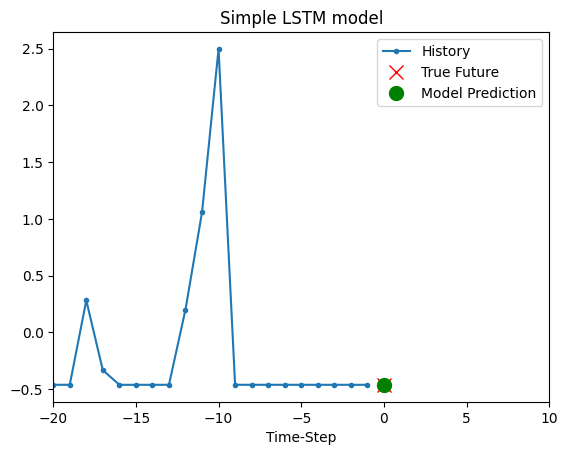

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


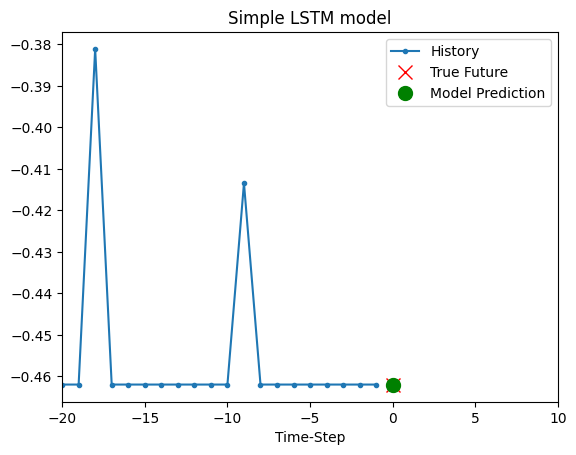

In [821]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()